In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import matplotlib as mpl
from keras import Model
from sklearn.model_selection import train_test_split
import os
import cv2 as cv
import tqdm
from sklearn.preprocessing import StandardScaler

2025-05-08 22:45:51.720575: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 22:45:51.756297: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-08 22:45:52.612735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# def convertToTFLite(keras_model, name):
#   converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
#   tflmodel = converter.convert()
#   file = open( name , 'wb' )
#   file.write( tflmodel )

In [3]:
def show_image(images: np.array, masks: np.array):
    """Displays images and their corresponding masks.

    Args:
        images (np.array): Array of images.
        masks (np.array): Array of masks.
    """
    # Masks_NORM = mpl.colors.Normalize(vmin=0, vmax=59)
    fig, axes = plt.subplots(images.shape[0], 2, figsize=(10, 10))

    # Handle single image case
    if images.shape[0] == 1:
        axes = [axes]  # Wrap axes in a list if only one image

    for ax, img, msk in zip(axes, images, masks):
        im1 = ax[0].imshow(img, cmap="gray")
        # im2 = ax[1].imshow(msk, cmap='gray', norm=Masks_NORM)
        im2 = ax[1].imshow(msk, cmap='gray')

        ax[0].set_title("Image")
        ax[1].set_title("Mask")

        fig.colorbar(im2, ax=ax[1], orientation='vertical')

    fig.tight_layout()

In [4]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [5]:
# def create_binary_mask(pred_mask):
#     pred_mask = tf.cast(pred_mask > 0.5, tf.uint8)
#     return pred_mask[0]

In [6]:
# # Paths
# # DATASET_PATH = "/home/cat/projects/CV-stuff/background_remover/datasets/people-clothing-segmentation"
# # IMAGES_PATH = DATASET_PATH + "/png_images/IMAGES/"
# # MASKS_PATH = DATASET_PATH + "/png_masks/MASKS/"
# # BINARY_MASKS_PATH = DATASET_PATH + "/binary_png_masks/MASKS/"
# # CLASS_NAMES_PATH = DATASET_PATH + "/labels.csv"

# # DATASET_PATH = "/home/cat/projects/CV-stuff/background_remover/datasets/clothessegmentation"
# DATASET_PATH = "/home/cat/projects/CV-stuff/background_remover/datasets/ClothesCombined-3"
# IMAGES_PATH = DATASET_PATH + "/Image/"
# BINARY_MASKS_PATH = DATASET_PATH + "/Mask/"


# # Sizes
# IMAGE_WIDTH = 256
# IMAGE_HEIGHT = 256

# # Train, Test, Validation Sizes
# TEST_SIZE = 0.2
# VALIDATION_SIZE = 0.2

In [7]:
# def load_dataset(path: str, size: tuple, grey: bool):

#     paths = []
#     for filename in tqdm.tqdm(os.listdir(path), "Scanning Path"):
#         file_path = os.path.join(path, filename)
#         if filename.endswith(".png"):
#             paths.append(file_path)


#     paths.sort()
#     images = []
#     for path in tqdm.tqdm(paths, "Loading Images"):

#         # Loading Image
#         if grey:
#           image = cv.imread(path, cv.IMREAD_GRAYSCALE)
#           if (len(np.unique(image))>2):
#             print(path)
#         else:

#           image = cv.imread(path, cv.IMREAD_COLOR)
#           image = cv.cvtColor(image, cv.COLOR_BGRA2RGB)

#         # Resize
#         image = cv.resize(image, size, interpolation=cv.INTER_NEAREST)

#         images.append(image)

#     print(f"✅ Loaded {len(paths)} Images.")
#     return np.array(images)

In [8]:
# images_ds = load_dataset(IMAGES_PATH, (IMAGE_WIDTH, IMAGE_HEIGHT), False)

In [9]:

# masks_ds = load_dataset(BINARY_MASKS_PATH, (IMAGE_WIDTH, IMAGE_HEIGHT), True)
# # Expaing dims
# masks_ds = masks_ds[:, :, :, np.newaxis]

In [10]:
# print("Images Dataset Shape", images_ds.shape)
# print("Masks Dataset Shape", masks_ds.shape)
# print(images_ds.shape[1:])
# print(np.unique(masks_ds))

In [11]:
# Normalizing
# images_ds = images_ds.astype(np.float32) / 255.0

In [12]:
# show_image(images_ds[:3], masks_ds[:3])

In [13]:
# x_train, x_test, y_train, y_test = train_test_split(images_ds, masks_ds, test_size=TEST_SIZE, random_state=10, shuffle=True)

In [14]:
# Paths

DATASET_PATH = "/home/cat/projects/CV-stuff/background_remover/datasets/clothing-dataset-full/resized"
IMAGES_PATH = DATASET_PATH + "/Image/"
BINARY_MASKS_PATH = DATASET_PATH + "/Mask/"


# Sizes
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

# Train, Test, Validation Sizes
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

In [15]:
def load_image_mask_dataset(image_dir, mask_dir, img_size=(256, 256), batch_size=32, shuffle=True):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(".png")])
    mask_paths  = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith(".png")])

    assert len(image_paths) == len(mask_paths), "Mismatch between image and mask count!"

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    def load_and_preprocess(image_path, mask_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, img_size)
        image = tf.cast(image, tf.float32) / 255.0

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, img_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        mask = tf.cast(mask, tf.int32)  # or leave as tf.uint8 if your model expects that

        return image, mask

    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=500)

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [16]:
dataset = load_image_mask_dataset(IMAGES_PATH, BINARY_MASKS_PATH, img_size=(256, 256), batch_size=4)

2025-05-08 22:45:55.752546: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-08 22:45:55.794976: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-08 22:45:55.795144: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
total = len(dataset)
train_count = int(total * 0.8)
print(total, train_count)



1318 1054


In [18]:
train_dataset = dataset.take(train_count)
val_dataset = dataset.skip(train_count)

In [19]:
# for img, mask in train_dataset.take(1):
#     print(img.shape, mask.shape)

In [20]:
print(len(val_dataset))

264


In [21]:
# def brigtness(img, mask):
#     # adjust brigtness of image, don't alter in mask
#     img = tf.image.adjust_brightness(img, 0.1)
#     return img, mask

# def hue(img, mask):
#     # adjust hue of image, don't alter in mask
#     img = tf.image.adjust_hue(img, -0.1)
#     return img, mask

# def crop(img, mask):
#     # crop both image and mask identically
#     img = tf.image.central_crop(img, 0.7)
#     mask = tf.image.central_crop(mask, 0.7)
#     img = tf.image.resize(img, (256, 256))
#     mask = tf.image.resize(mask, (256, 256))
#     mask = tf.cast(mask, tf.uint8)
#     return img, mask

# def flip_horizontal(img, mask):
#     # flip both image and mask identically
#     img = tf.image.flip_left_right(img)
#     mask = tf.image.flip_left_right(mask)
#     return img, mask

# def flip_vertical(img, mask):
#     # flip both image and mask identically
#     img = tf.image.flip_up_down(img)
#     mask = tf.image.flip_up_down(mask)
#     return img, mask

# def rotate(img, mask):
#     # rotate both image and mask identically
#     img = tf.image.rot90(img)
#     mask = tf.image.rot90(mask)
#     return img, mask

In [22]:
# def preprocessing_data(train_X, test_X, train_y, test_y, BATCH_SIZE=64, BUFFER_SIZE=1000):
#     train_X = tf.data.Dataset.from_tensor_slices(train_X.copy())
#     test_X = tf.data.Dataset.from_tensor_slices(test_X.copy())
#     train_y = tf.data.Dataset.from_tensor_slices(train_y.copy().astype(np.uint8))
#     test_y = tf.data.Dataset.from_tensor_slices(test_y.copy().astype(np.uint8))
#     # zip images and masks
#     train = tf.data.Dataset.zip((train_X, train_y))
#     test = tf.data.Dataset.zip((test_X, test_y))
#     # Perform augmentation on train data only
#     a = train.map(brigtness)
#     b = train.map(hue)
#     c = train.map(crop)
#     d = train.map(flip_horizontal)
#     e = train.map(flip_vertical)
#     f = train.map(rotate)
#     # Concatenate every new augmented data
#     for aug_data in [a, b, c, d, e, f]:
#         train = train.concatenate(aug_data)
#     # shuffle and group the train set into batches
#     train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#     # do a prefetch to optimize processing
#     train = train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#     # group the test set into batches
#     test = test.batch(BATCH_SIZE)
#     return train, test

In [23]:
# train, test = preprocessing_data(x_train, x_test, y_train, y_test, BATCH_SIZE=16)

In [24]:
# import unet
# model = unet.createModel()
# model.load_weights("model_unet_after_i_style.weights.h5")

In [25]:
import unet2
model = unet2.build_u2net_lite((256, 256, 3), 2)
model.load_weights("unet2_1.weights.h5")

In [26]:
# import unet_other
# model = unet_other.get_unet_model('unet_simple', 2, (256, 256))

In [27]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [28]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [29]:
def show_predictions(epoch, dataset=None, num=1):
  if dataset:

    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        plt.figure(figsize=(15, 10))
        plt.subplot(231)
        plt.title('Testing Image')
        plt.imshow(image[0], cmap='gray')
        plt.subplot(232)
        plt.title('Ground Truth')
        plt.imshow(mask[0], cmap='gray')
        plt.subplot(233)
        plt.title('Prediction on test image')
        plt.imshow(create_mask(pred_mask), cmap='gray')

        plt.show()
  else:
      fig = plt.figure(figsize=(12, 12))
      fig.suptitle(f"\n Epoch: {str(epoch)}\n", fontsize=16)

      plt.subplot(331)
      plt.title('Testing Image')
      plt.imshow(x_train[num], cmap='gray')
      plt.subplot(332)
      plt.title('Ground Truth')
      plt.imshow(y_train[num], cmap='gray')
      plt.subplot(333)
      plt.title('Prediction on test image')
      plt.imshow(create_mask(model.predict(x_train[num][tf.newaxis, ...]))[:,:,0], cmap='gray')

      plt.subplot(334)
      plt.imshow(x_train[num+16], cmap='gray')
      plt.subplot(335)
      plt.imshow(y_train[num+16], cmap='gray')
      plt.subplot(336)
      plt.imshow(create_mask(model.predict(x_train[num+16][tf.newaxis, ...]))[:,:,0], cmap='gray')
      plt.subplot(337)
      plt.imshow(x_train[num+14], cmap='gray')
      plt.subplot(338)
      plt.imshow(y_train[num+14], cmap='gray')
      plt.subplot(339)
      plt.imshow(create_mask(model.predict(x_train[num+14][tf.newaxis, ...]))[:,:,0], cmap='gray')

      plt.show()

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(epoch, train_dataset)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/10


I0000 00:00:1746737195.368020  514632 service.cc:145] XLA service 0x7adcd8002550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746737195.368085  514632 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-05-08 22:46:36.847309: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1746737198.951308  514632 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-05-08 22:46:41.427909: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-05-08 22:46:57.103942: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9806 - loss: 0.0556

W0000 00:00:1746737548.055769  514626 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1746737572.750676  514632 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


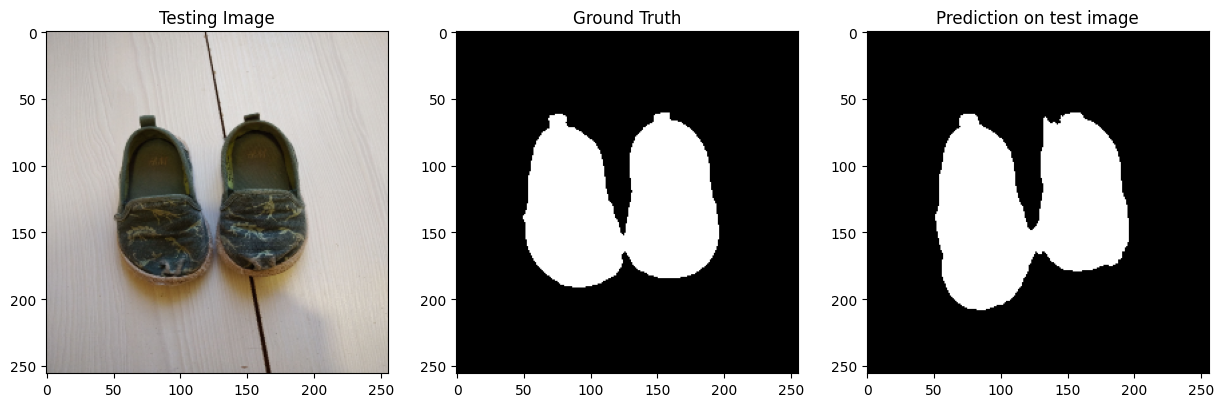


Sample Prediction after epoch 1

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 428s 310ms/step - accuracy: 0.9806 - loss: 0.0556 - val_accuracy: 0.9776 - val_loss: 0.0699
Epoch 2/10


2025-05-08 22:53:05.362793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/stepms/step - accuracy: 0.9831 - loss: 0.048


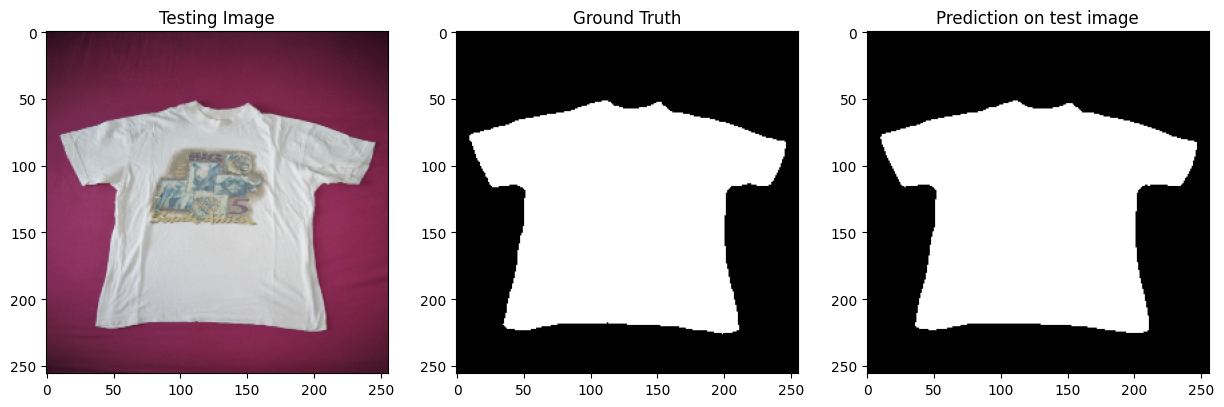


Sample Prediction after epoch 2

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 346s 327ms/step - accuracy: 0.9831 - loss: 0.0488 - val_accuracy: 0.9721 - val_loss: 0.0803
Epoch 3/10


2025-05-08 22:58:51.926501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/stepms/step - accuracy: 0.9824 - loss: 0.050


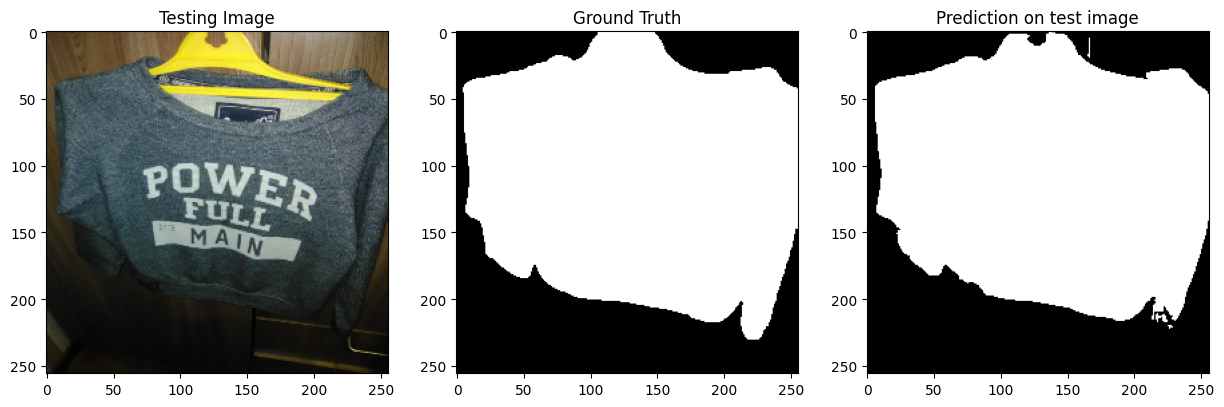


Sample Prediction after epoch 3

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 345s 326ms/step - accuracy: 0.9824 - loss: 0.0507 - val_accuracy: 0.9849 - val_loss: 0.0467
Epoch 4/10


2025-05-08 23:04:36.681920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/stepms/step - accuracy: 0.9841 - loss: 0.045


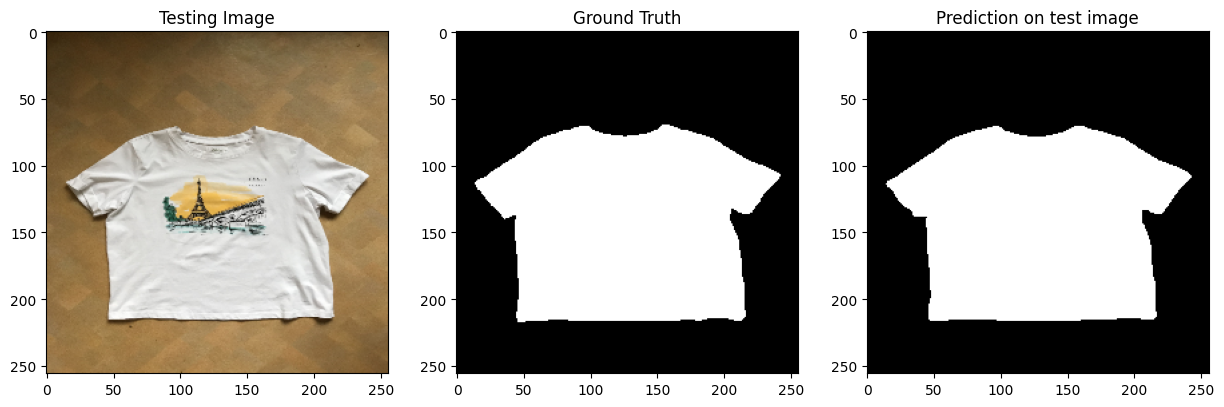


Sample Prediction after epoch 4

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 358s 338ms/step - accuracy: 0.9841 - loss: 0.0458 - val_accuracy: 0.9830 - val_loss: 0.0519
Epoch 5/10


2025-05-08 23:10:34.372055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/stepms/step - accuracy: 0.9835 - loss: 0.046


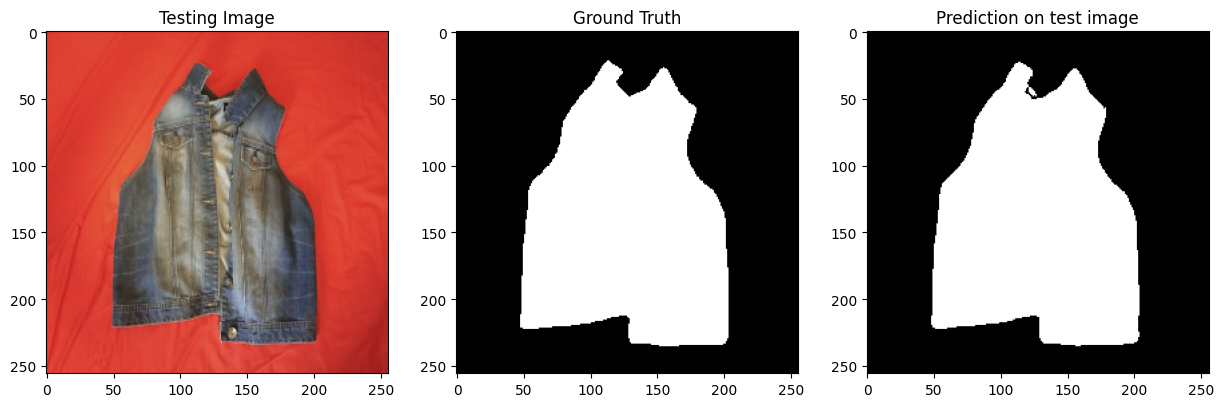


Sample Prediction after epoch 5

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 365s 345ms/step - accuracy: 0.9835 - loss: 0.0468 - val_accuracy: 0.9753 - val_loss: 0.0726
Epoch 6/10


2025-05-08 23:16:39.536477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/stepms/step - accuracy: 0.9853 - loss: 0.041


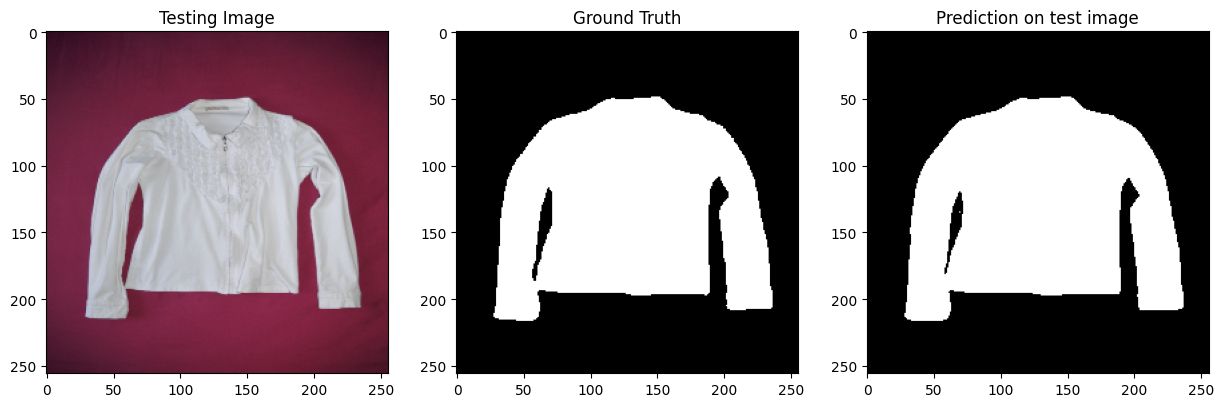


Sample Prediction after epoch 6

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 363s 344ms/step - accuracy: 0.9853 - loss: 0.0414 - val_accuracy: 0.9780 - val_loss: 0.0685
Epoch 7/10


2025-05-08 23:22:42.756737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/stepms/step - accuracy: 0.9868 - loss: 0.037


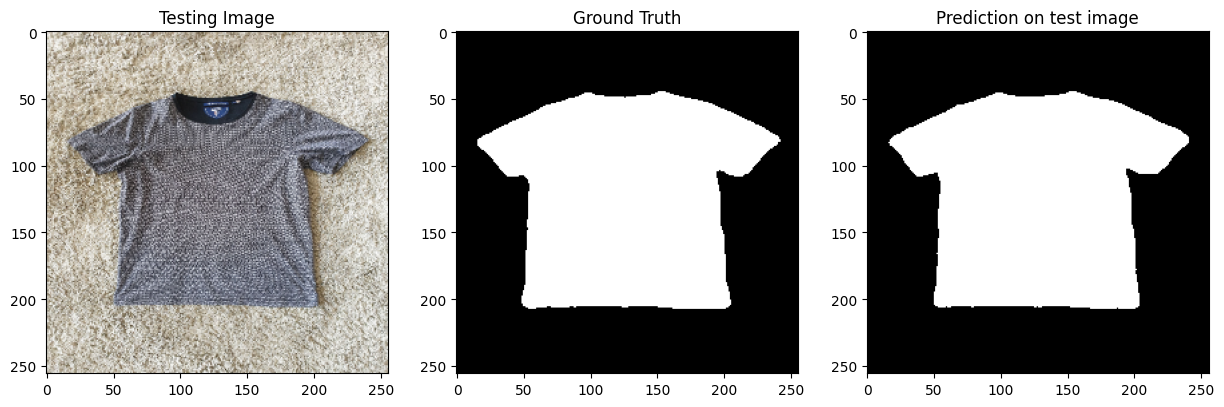


Sample Prediction after epoch 7

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 362s 342ms/step - accuracy: 0.9868 - loss: 0.0372 - val_accuracy: 0.9849 - val_loss: 0.0468
Epoch 8/10


2025-05-08 23:28:45.049144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/stepms/step - accuracy: 0.9869 - loss: 0.036


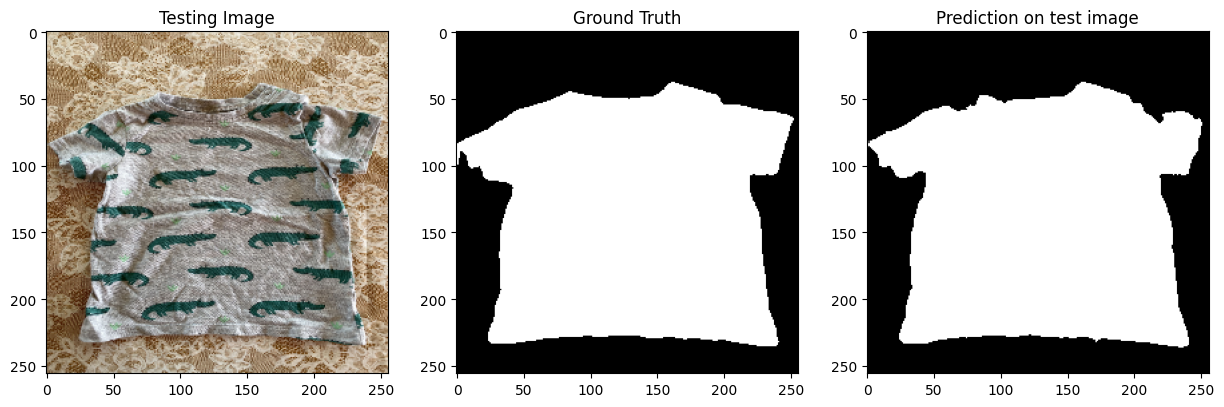


Sample Prediction after epoch 8

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 354s 335ms/step - accuracy: 0.9869 - loss: 0.0364 - val_accuracy: 0.9838 - val_loss: 0.0500
Epoch 9/10


2025-05-08 23:34:38.759173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/stepms/step - accuracy: 0.9884 - loss: 0.031


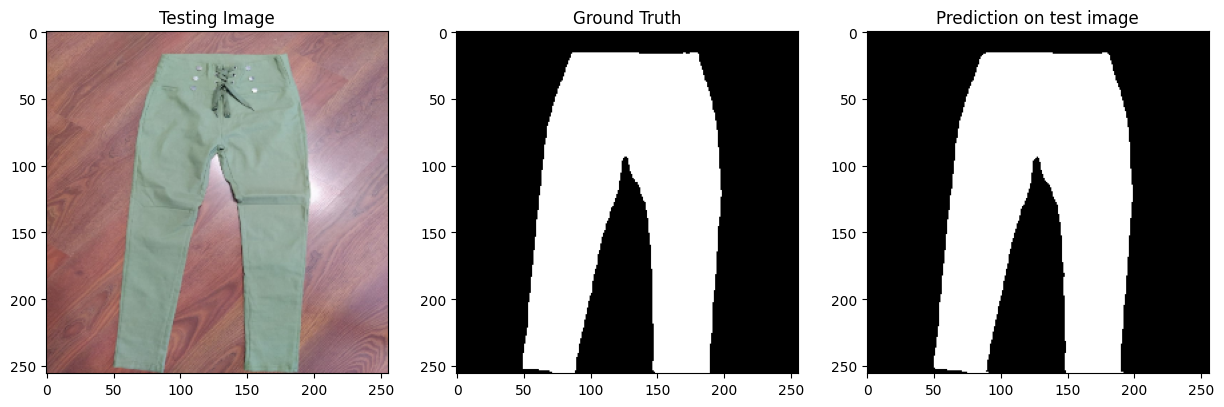


Sample Prediction after epoch 9

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 359s 339ms/step - accuracy: 0.9884 - loss: 0.0319 - val_accuracy: 0.9862 - val_loss: 0.0419
Epoch 10/10


2025-05-08 23:40:37.254833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/stepms/step - accuracy: 0.9891 - loss: 0.030


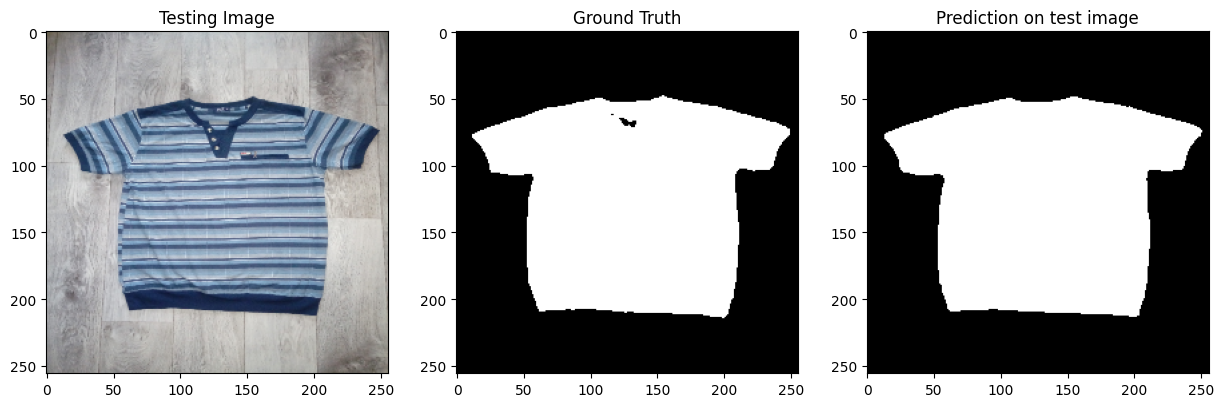


Sample Prediction after epoch 10

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 358s 339ms/step - accuracy: 0.9891 - loss: 0.0303 - val_accuracy: 0.9834 - val_loss: 0.0539


2025-05-08 23:46:35.717289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
# with tf.device("/GPU:0"):
#     hist2 = model.fit(
#         x_train,
#         y_train,
#         batch_size=16,
#         epochs=50,
#         validation_data=(x_test, y_test),
#         callbacks=[DisplayCallback(), early_stopping]
#     )

with tf.device("/GPU:0"):
    hist = model.fit(
        train_dataset,
        epochs=10,
        validation_data=val_dataset,
        callbacks=[DisplayCallback(), early_stopping]
    )

In [31]:
model.save_weights("unet2_2.weights.h5")

In [32]:
def plot_history(hist):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.show()

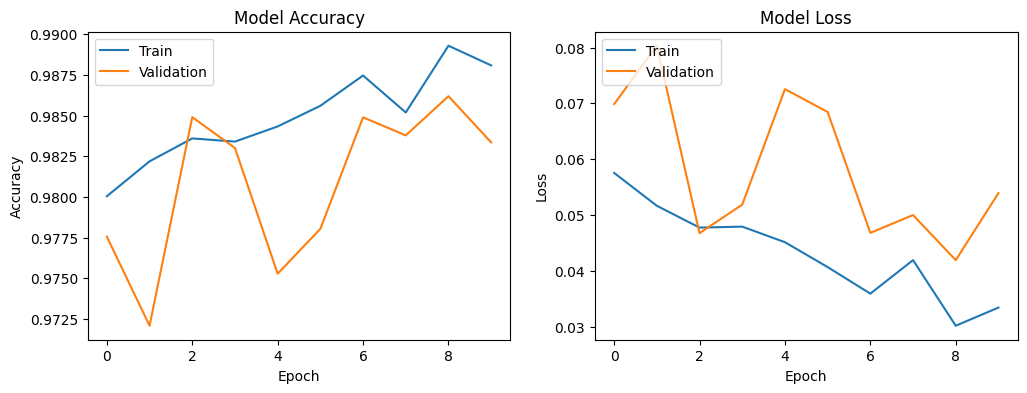

In [33]:
plot_history(hist)